In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sep
import math
import keras
import numpy as np
from astropy.io import fits
from astropy.visualization import ZScaleInterval
from astropy import wcs
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord


import aplpy
from astroquery.sdss import SDSS

Using TensorFlow backend.


IMAGE FROM CTMO

In [2]:
hdu_ctmo = fits.open("kw_data/ic4559/stack-ctmo-ic4559.fit")

In [3]:
data_ctmo = hdu_ctmo[0].data

In [4]:
hdu_ctmo[0].header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    2 / Number of axes                                 
NAXIS1  =                 2048 / Axis length                                    
NAXIS2  =                 2048 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
DATE    = '2020-01-15T02:20:02' / Date FITS file was generated                  
IRAF-TLM= '2020-01-15T02:20:01' / Time of last modification                     
OBJECT  = 'ic4559  '           / Name of the object observed                    
DATE-OBS= '2019-07-02T03:56:45' /YYYY-MM-DDThh:mm:ss observation start, UT      
EXPTIME =   300.00000000000000 /Exposure time in seconds                        
EXPOSURE=   300.000000000000

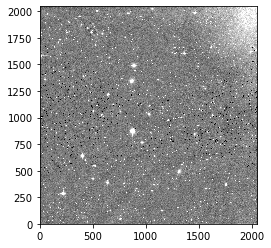

In [5]:
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(data_ctmo)

plt.imshow(data_ctmo, vmin=vmin, vmax=vmax, origin='lower',cmap='gray')
plt.imsave('image_ctmo.png', data_ctmo, vmin=vmin, vmax=vmax, origin='lower',cmap='gray')

IMAGE FROM SDSS

In [6]:
from astroquery.skyview import SkyView
from astropy import coordinates as coords
from astropy.coordinates import SkyCoord
import astropy.units as u

#frame_coord = SkyCoord(ra=center_ra * u.deg, dec=center_dec * u.deg).icrs
fov_radius = 50 * u.arcmin
pos = coords.SkyCoord('15h35m53.5178382775s +25d20m28.078077492s', frame='icrs')

hdu_sdss = SkyView.get_images(position=pos, coordinates='icrs', pixels=2000,
                         survey='SDSSg', radius=fov_radius)[0]

In [7]:
hdu_sdss[0].header

SIMPLE  =                    T / Written by SkyView Thu Jan 16 15:12:12 EST 2020
BITPIX  =                  -32 / 4 byte floating point                          
NAXIS   =                    2 / Two dimensional image                          
NAXIS1  =                 2000 / Width of image                                 
NAXIS2  =                 2000 / Height of image                                
CRVAL1  =              233.973 / Reference longitude                            
CRVAL2  =              25.3411 / Reference latitude                             
RADESYS = 'FK5     '           / Coordinate system                              
EQUINOX =                 2000 / ICRS coordinates                               
CTYPE1  = 'RA---TAN'           / Coordinates -- projection                      
CTYPE2  = 'DEC--TAN'           / Coordinates -- projection                      
CRPIX1  =               1000.5 / X reference pixel                              
CRPIX2  =               1000

In [8]:
data_sdss = hdu_sdss[0].data

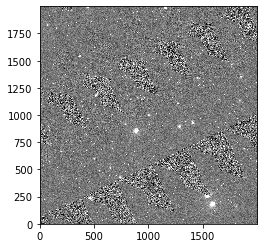

In [9]:
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(data_sdss)
plt.imshow(data_sdss, vmin=vmin, vmax=vmax, origin='lower',cmap='gray')
plt.imsave('image_sdss.png', data_sdss, vmin=vmin, vmax=vmax, origin='lower',cmap='gray')

ALIGNING IMAGES

In [10]:
from reproject import reproject_interp
data_sdss_fitted, footprint = reproject_interp(hdu_sdss[0], hdu_ctmo[0].header)

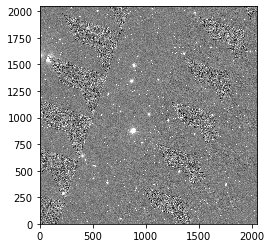

In [11]:
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(data_sdss_fitted)
plt.imshow(data_sdss_fitted, vmin=vmin, vmax=vmax, origin='lower',cmap='gray')
plt.imsave('image_sdss_fitted.png', data_sdss_fitted, vmin=vmin, vmax=vmax, origin='lower',cmap='gray')

OBJECT DETECTION - CTMO IMAGE 

In [12]:
bkg = sep.Background(data_ctmo.astype("f8"),bw=128, bh=128, fw=3, fh=3)
sigma = bkg.globalrms

data_ctmo = data_ctmo.byteswap().newbyteorder()

objects = sep.extract(data_ctmo, 3*sigma, err=bkg.globalrms)

In [13]:
len(objects)

321

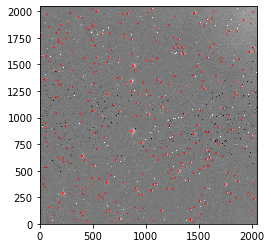

In [14]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_ctmo), np.std(data_ctmo)
im = ax.imshow(data_ctmo, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

In [27]:
objects['x'][0], objects['y'][0]

(1454.4951918889549, 16.92729614839502)

In [15]:
objects_coord = []

for i in range (0,len(objects)):
    objects_coord.append([objects['x'][i], objects['y'][i]])
    
objects_coord = np.array(objects_coord)

In [52]:
objects_coord.shape[0]

321

array([[1454.49519189,   16.92729615],
       [ 681.92793767,   19.63317089],
       [ 445.32197862,   21.78509394],
       [1075.17619829,   29.06503   ],
       [  80.57593214,   29.39745125],
       [1425.39205882,   34.22123621],
       [ 349.0214518 ,   41.69404321],
       [ 929.79026988,   42.06511804],
       [1420.07064313,   45.23204927],
       [ 752.78395929,   46.79961855],
       [1491.50959533,   50.84541175],
       [ 132.07988053,   75.95530872],
       [ 405.45821864,   76.21799681],
       [1522.24417972,   87.00322691],
       [ 827.8987107 ,   97.35845867],
       [ 733.88623741,  104.84843887],
       [ 390.78542716,  105.46726308],
       [ 418.98496264,  107.02053405],
       [ 633.90973087,  114.71607669],
       [ 319.81319911,  116.55920492],
       [2017.40715209,  125.19938075],
       [1146.11654675,  125.20849162],
       [ 660.12330966,  130.46752913],
       [1420.93714694,  137.2753941 ],
       [ 981.84465472,  145.91607861],
       [ 898.8050633 ,  1

CREATING DATASET

In [16]:
def cut_object(im, x,y,l):
    x = int(round(x))
    y = int(round(y))
    
    return im[y-l:y+l+1, x-l:x+l+1]

In [17]:
def creating_dataset (im, coord):
    
    images = []
    for i in range (0,coord.shape[0]):

        if (coord[i][0] < im.shape[1]-21 and coord[i][1] < im.shape[0]-21):
            print(i)
            images.append(cut_object(im, coord[i][0], coord[i][1],10))
            #images[i,:,:] = cut_object(im, objects['x'][i], objects['y'][i],10)
            
    images = np.array(images)
    return images

In [18]:
dataset_ctmo = creating_dataset(data_ctmo, objects_coord)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

In [19]:
dataset_ctmo.shape

(320, 21, 21)

In [20]:
dataset_sdss = creating_dataset(data_sdss_fitted, objects_coord)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

In [21]:
dataset_sdss.shape

(320, 21, 21)

In [22]:
dataset_ic4559 = np.zeros((dataset_ctmo.shape[0],21,21,2))

In [23]:
dataset_ic4559.shape

(320, 21, 21, 2)

In [24]:
dataset_ic4559[:,:,:,0] = dataset_ctmo
dataset_ic4559[:,:,:,1] = dataset_sdss

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


/home/kasiawardega/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


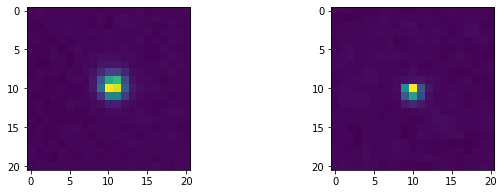

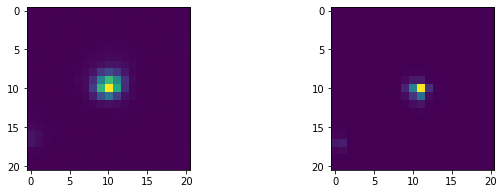

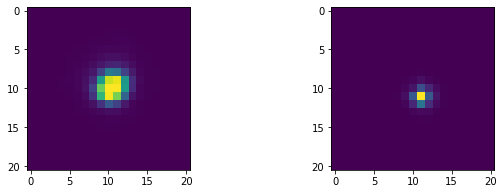

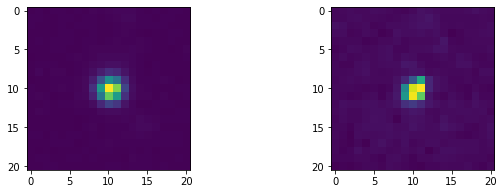

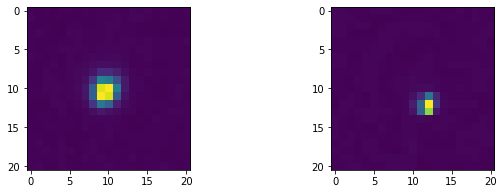

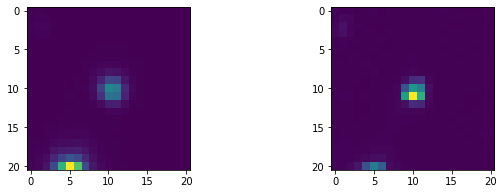

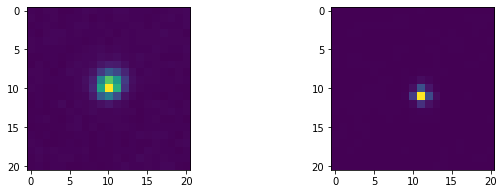

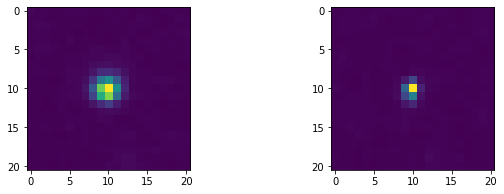

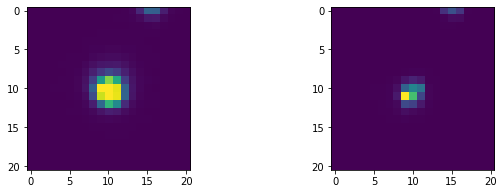

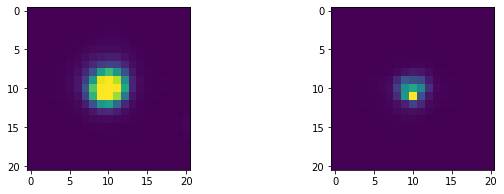

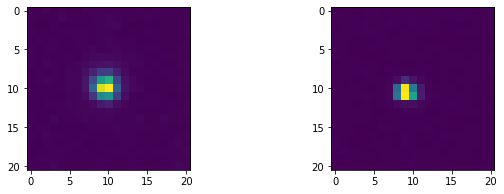

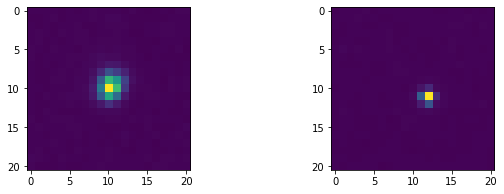

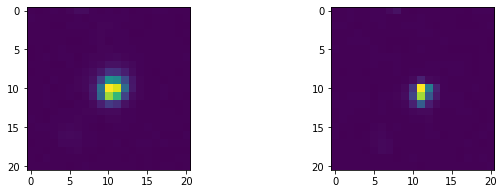

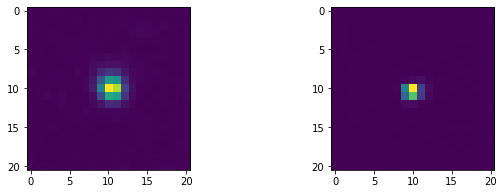

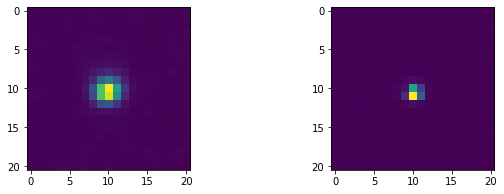

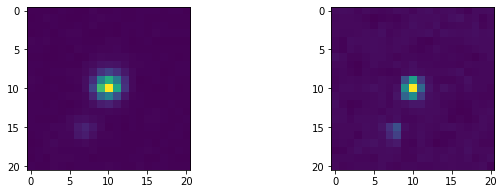

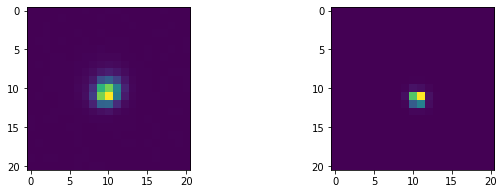

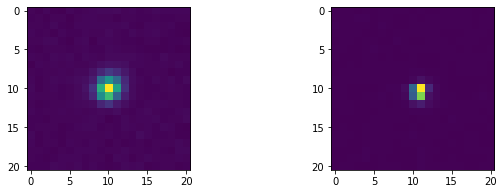

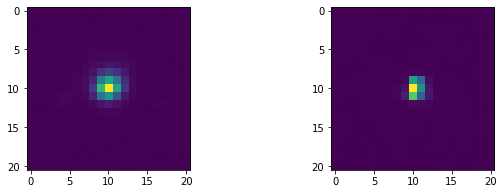

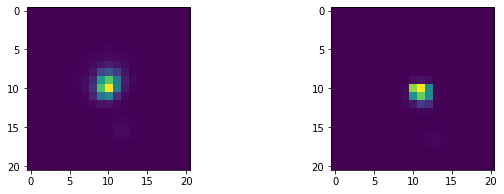

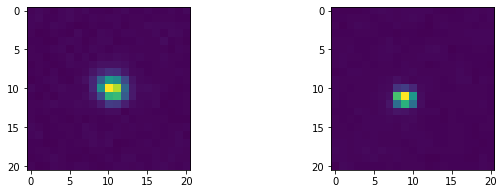

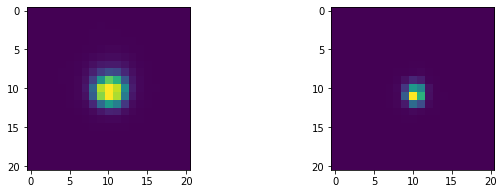

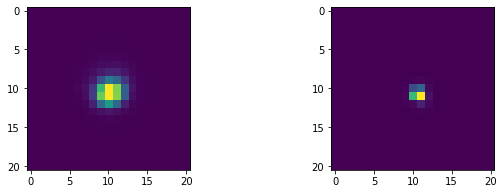

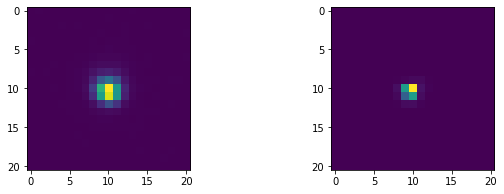

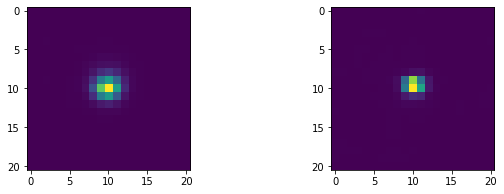

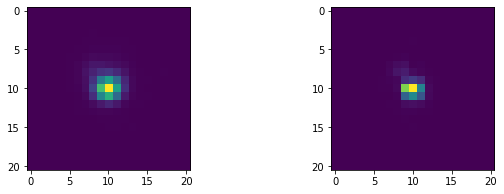

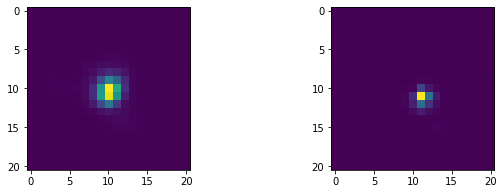

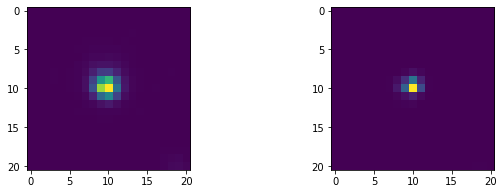

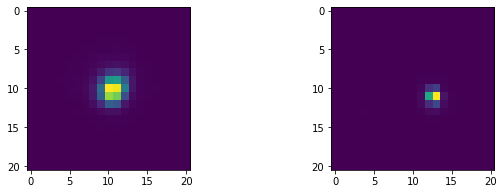

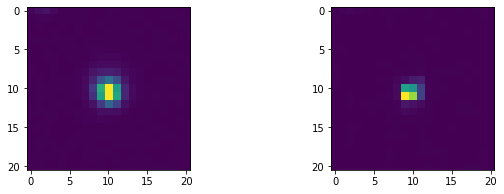

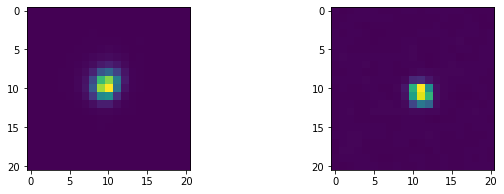

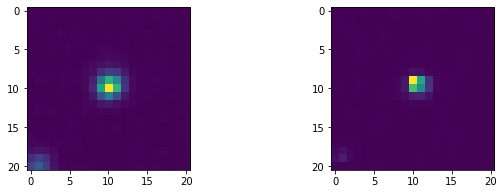

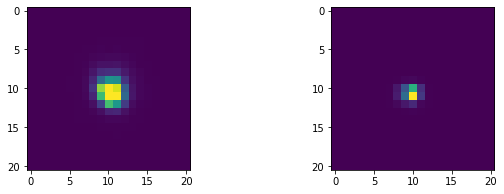

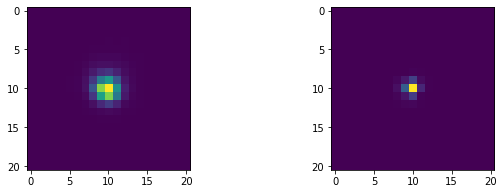

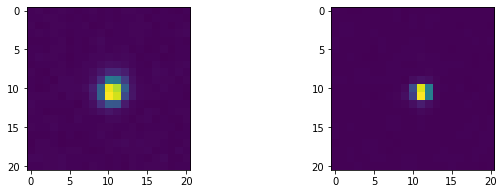

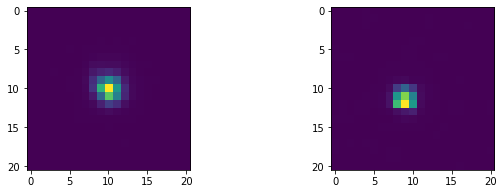

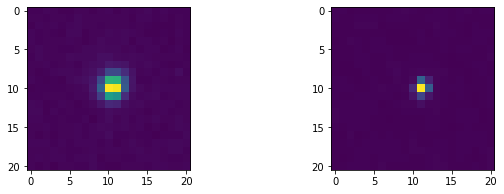

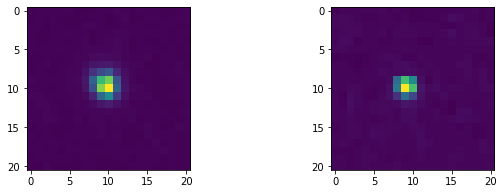

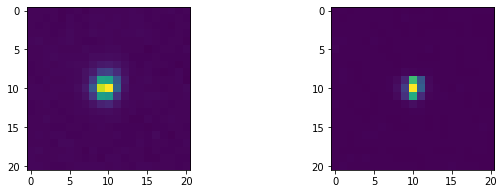

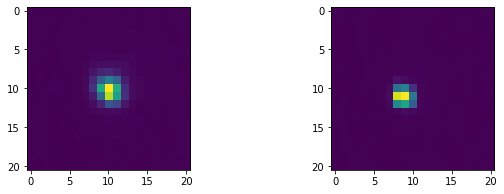

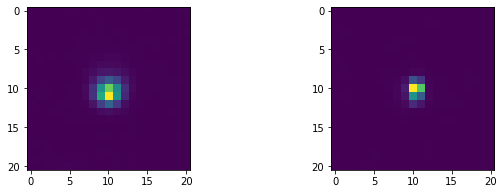

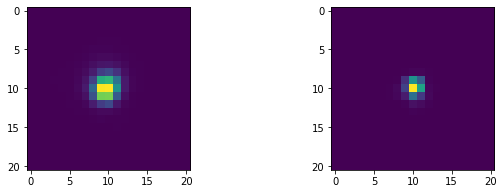

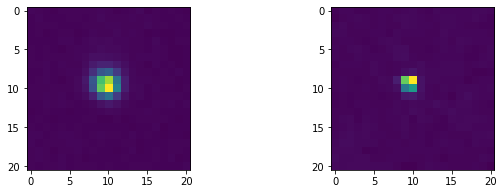

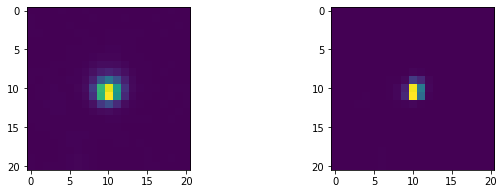

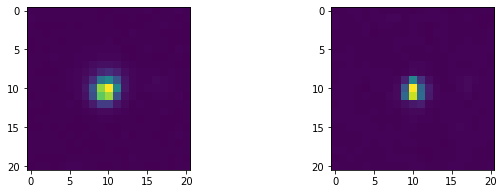

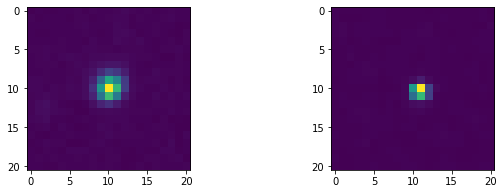

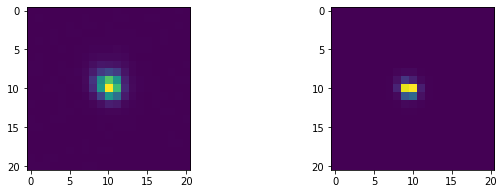

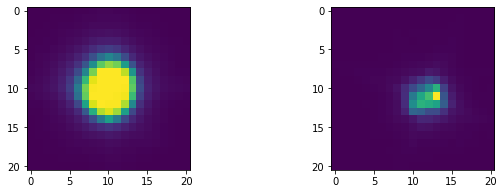

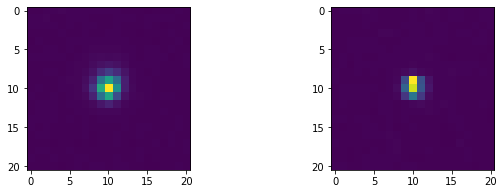

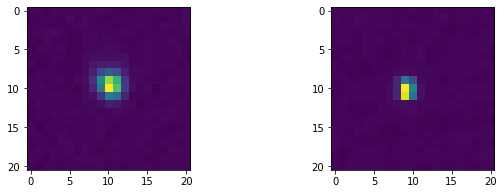

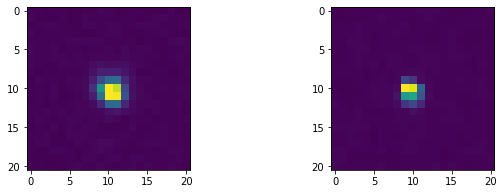

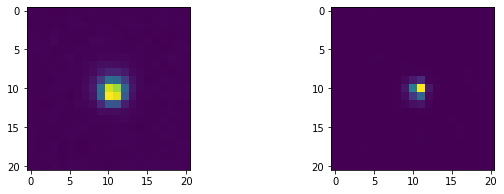

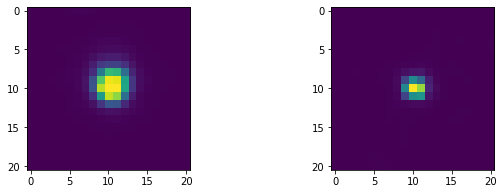

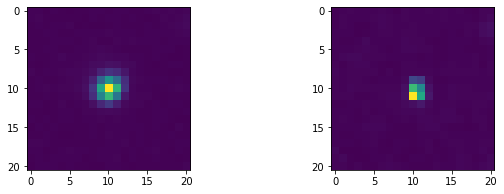

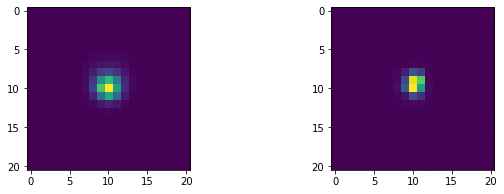

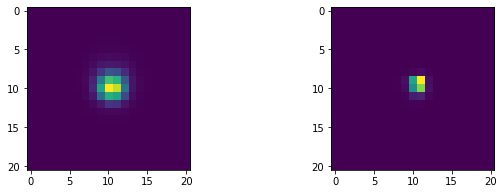

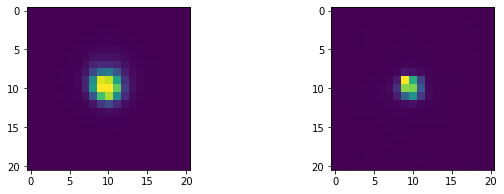

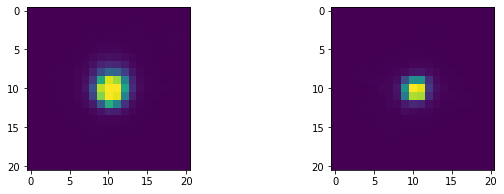

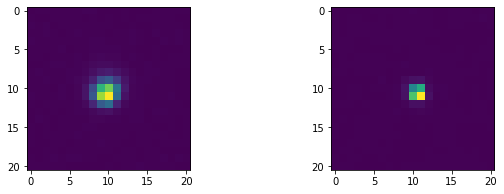

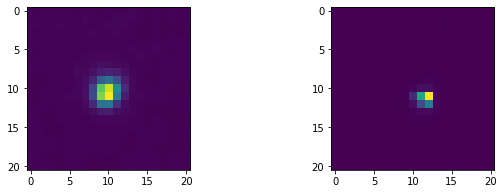

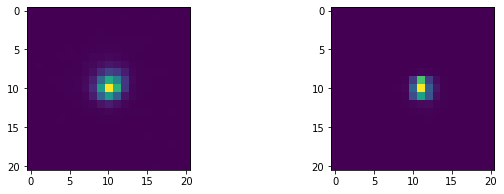

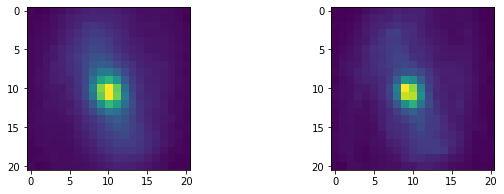

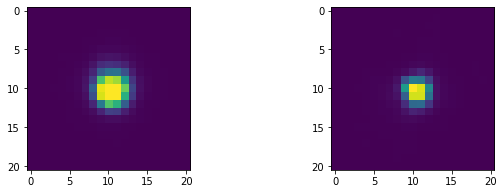

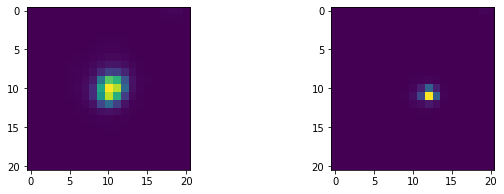

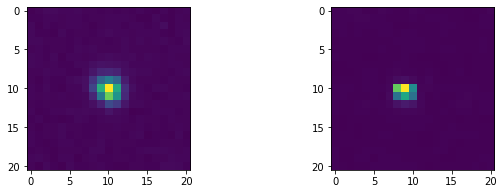

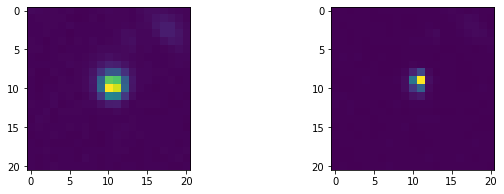

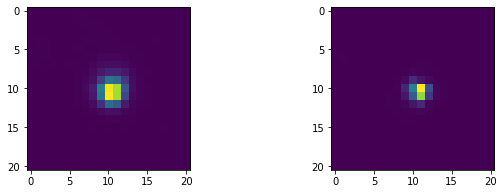

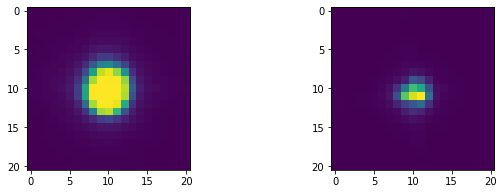

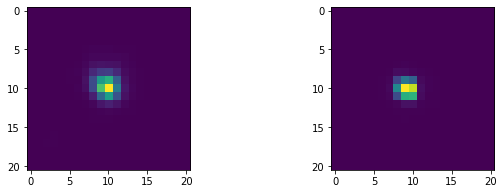

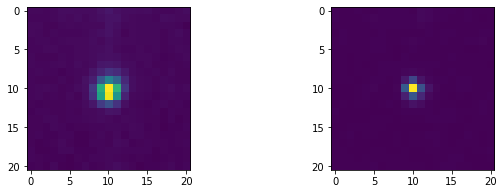

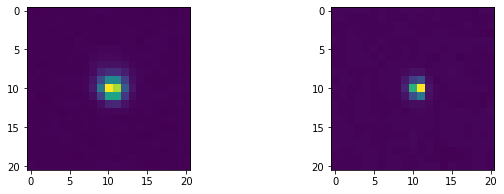

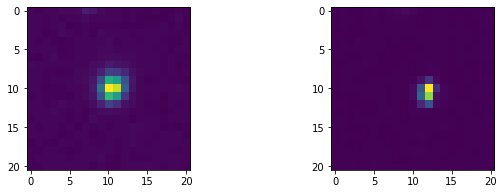

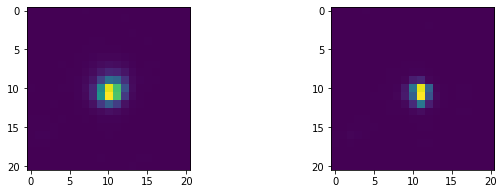

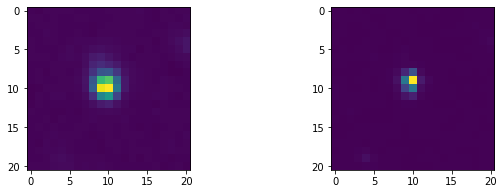

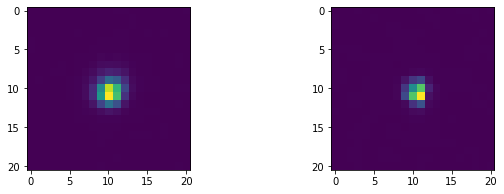

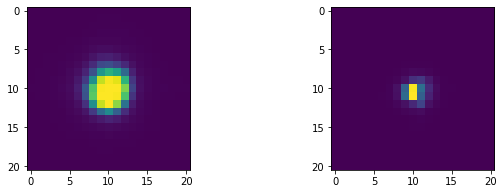

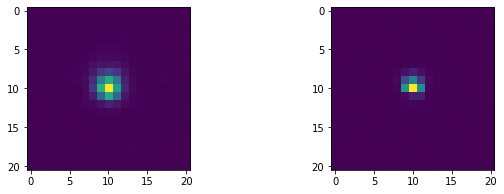

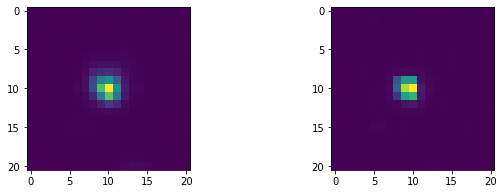

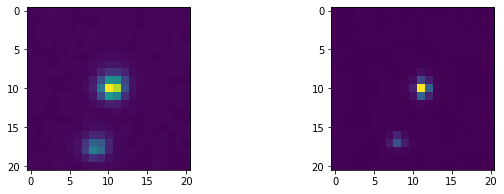

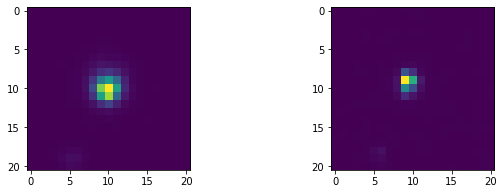

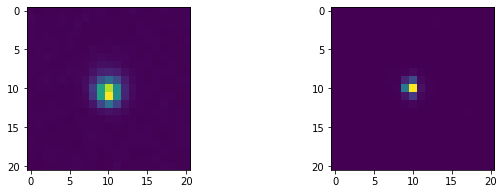

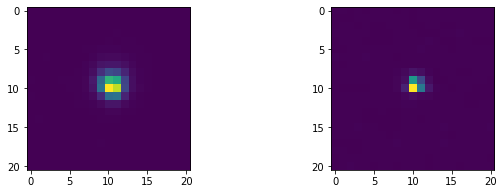

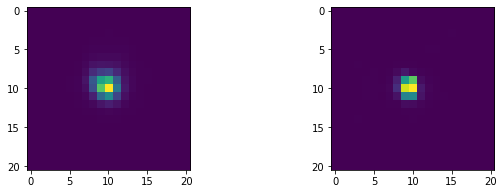

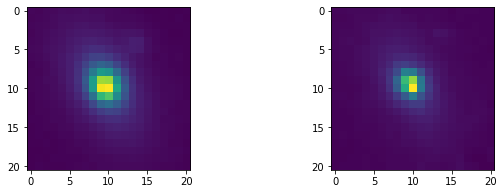

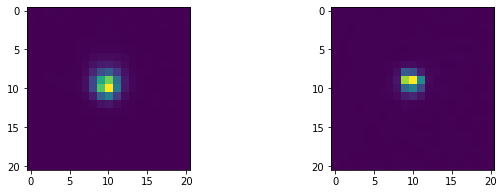

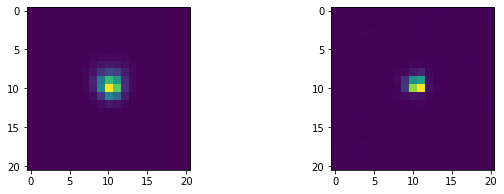

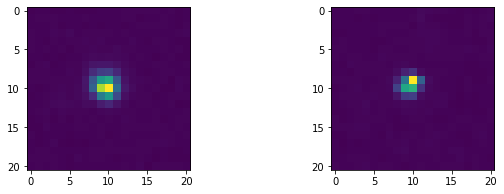

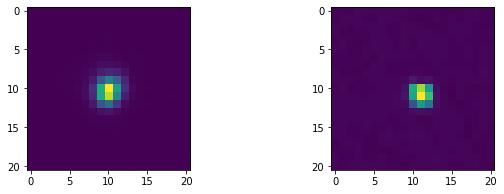

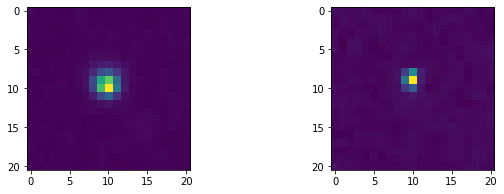

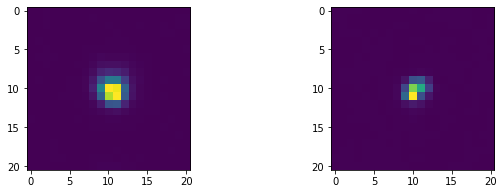

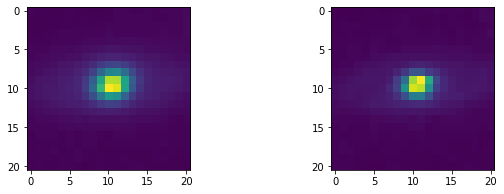

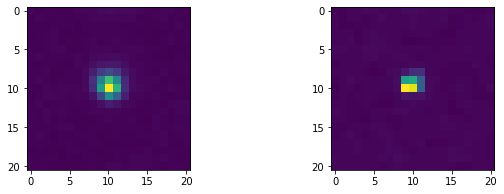

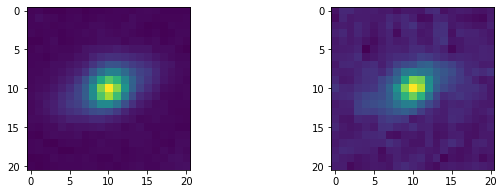

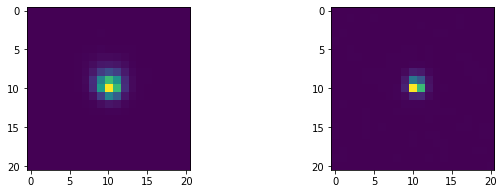

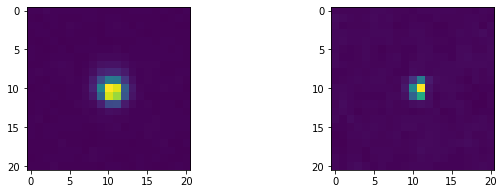

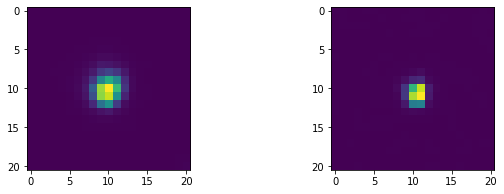

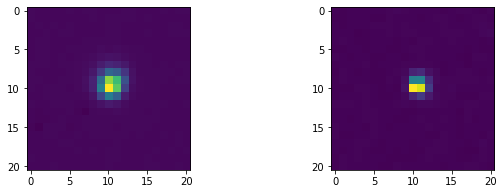

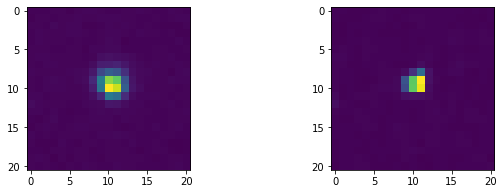

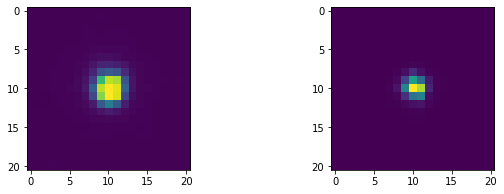

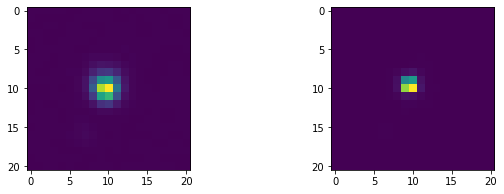

In [30]:
for i in range(100):
    f = plt.figure(figsize=(10,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)    
    ax.imshow(dataset_ic4559[i,:,:,0])
    ax2.imshow(dataset_ic4559[i,:,:,1])


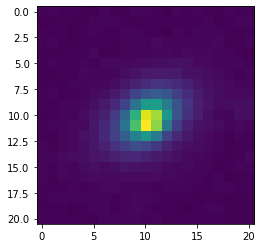

In [65]:
plt.imshow(dataset_ic4559[132,:,:,0])
plt.imsave('ctmo_image132.png', dataset_ic4559[132,:,:,0])

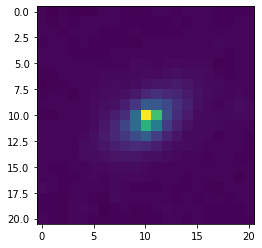

In [66]:
plt.imshow(dataset_ic4559[132,:,:,1])
plt.imsave('sdss_image132.png', dataset_ic4559[132,:,:,1])

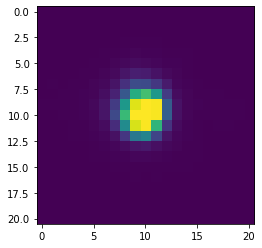

In [50]:
plt.imshow(dataset_ic4559[100,:,:,0])